![Cabec%CC%A7alho_notebook.png](cabecalho_notebook.png)

# Classificação de Atividade Humana com PCA

Vamos trabalhar com a base da demonstração feita em aula, mas vamos explorar um pouco melhor como é o desempenho da árvore variando o número de componentes principais.

In [46]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import timeit

filename_features = "data/UCI HAR Dataset/features.txt"
filename_labels = "data/UCI HAR Dataset/activity_labels.txt"

filename_subtrain = "data/UCI HAR Dataset/train/subject_train.txt"
filename_xtrain = "data/UCI HAR Dataset/train/X_train.txt"
filename_ytrain = "data/UCI HAR Dataset/train/y_train.txt"

filename_subtest = "data/UCI HAR Dataset/test/subject_test.txt"
ffilename_xtest = "data/UCI HAR Dataset/test/X_test.txt"
filename_ytest = "data/UCI HAR Dataset/test/y_test.txt"

features = pd.read_csv(filename_features, header=None, names=['nome_var'], sep="#").squeeze("columns")
labels = pd.read_csv(filename_labels, delim_whitespace=True, header=None, names=['cod_label', 'label'])

subject_train = pd.read_csv(filename_subtrain, header=None, names=['subject_id']).squeeze("columns")
X_train = pd.read_csv(filename_xtrain, delim_whitespace=True, header=None, names=features.tolist())
y_train = pd.read_csv(filename_ytrain, header=None, names=['cod_label'])

subject_test = pd.read_csv(filename_subtest, header=None, names=['subject_id']).squeeze("columns")
X_test = pd.read_csv(ffilename_xtest, delim_whitespace=True, header=None, names=features.tolist())
y_test = pd.read_csv(filename_ytest, header=None, names=['cod_label'])

In [47]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train)

## PCA com variáveis padronizadas

Reflexão sobre a escala das variáveis:

**Variáveis em métricas muito diferentes** podem interferir na análise de componentes principais. Lembra que variância é informação pra nós? Pois bem, tipicamente se há uma variável monetária como salário, vai ter uma ordem de variabilidade bem maior que número de filhos, tempo de emprego ou qualquer variável dummy. Assim, as variáveis de maior variância tendem a "dominar" a análise. Nesses casos é comum usar a padronização das variáveis.

In [48]:
%%time

def padroniza(s):
    if s.std() > 0:
        s = (s - s.mean())/s.std()
    return s

X_train_pad = pd.DataFrame(X_train).apply(padroniza, axis=0)
X_valid_pad = pd.DataFrame(X_valid).apply(padroniza, axis=0)
X_test_pad = pd.DataFrame(X_test).apply(padroniza, axis=0)

CPU times: user 502 ms, sys: 45.8 ms, total: 548 ms
Wall time: 555 ms


Faça duas análises de componentes principais para a base do HAR - com e sem padronização e compare:

- A variância explicada por componente
- A variância explicada acumulada por componente
- A variância percentual por componente
- A variância percentual acumulada por componente
- Quantas componentes você escolheria, em cada caso para explicar 90% da variância?

In [49]:
def pca_graph(pca):

    fig, ax = plt.subplots(2, 2, sharex=True, figsize=(14, 8))
    plt.subplots_adjust(hspace=0, wspace=.15)

    num_componentes = np.arange(pca.n_components_) + 1
    ax[0,0].plot(num_componentes, pca.explained_variance_, 'o-', linewidth=2, color='blue', markersize=2, alpha=.2)
    ax[0,0].set_title('Scree Plot - Variância total')
    ax[0,0].set_xlabel('Número de componentes')
    ax[0,0].set_ylabel('Variancia explicada (Autovalores)')

    ax[1,0].plot(num_componentes, pca.explained_variance_.cumsum(), 'o-', linewidth=2, color='blue', markersize=2, alpha=.2)
    ax[1,0].set_xlabel('Número de componentes')
    ax[1,0].set_ylabel('Variancia explicada (Acumulada)')

    ax[0,1].plot(num_componentes, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue', markersize=2, alpha=.2)
    ax[0,1].set_title('Scree Plot - Variância percentual')
    ax[0,1].set_xlabel('Número de componentes')
    ax[0,1].set_ylabel('Variancia explicada (percentual)')

    ax[1,1].plot(num_componentes, pca.explained_variance_ratio_.cumsum(), 'o-', linewidth=2, color='blue', markersize=2, alpha=.2)
    ax[1,1].set_xlabel('Número de componentes')
    ax[1,1].set_ylabel('Variancia explicada (% Acumulado)')

    plt.show()

In [50]:
prcomp_npad = PCA().fit(X_train)
prcomp_pad = PCA().fit(X_train_pad)

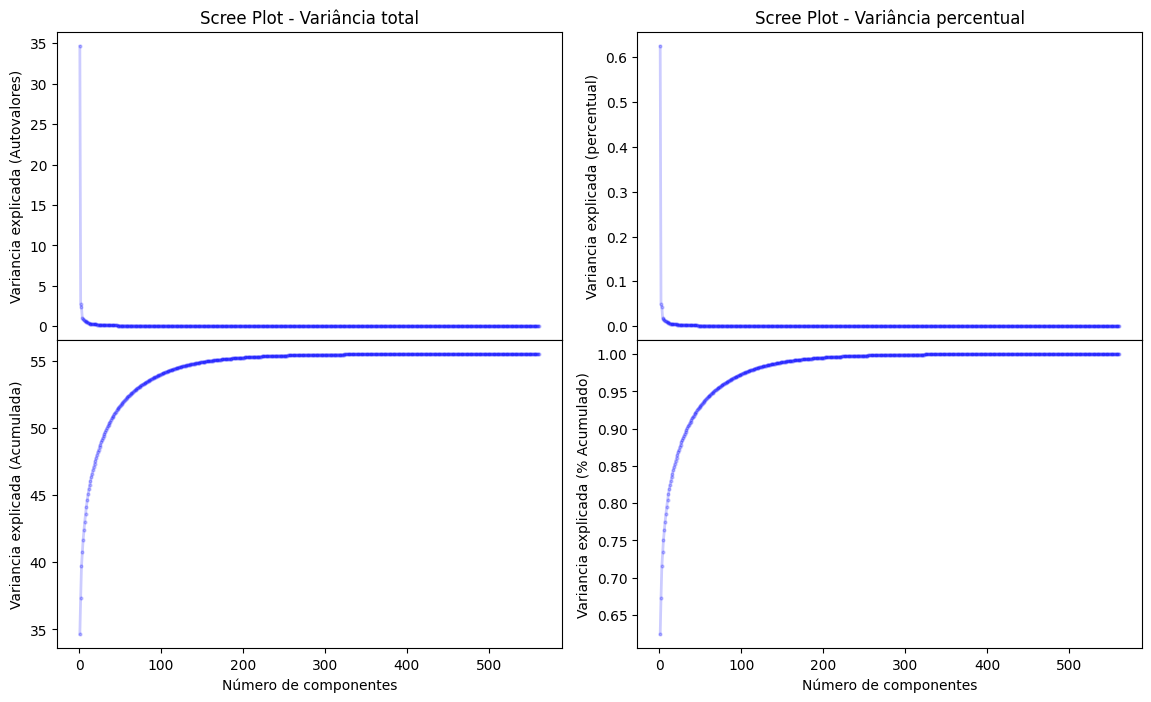

In [51]:
pca_graph(prcomp_npad)

## Árvore com PCA

Faça duas uma árvore de decisão com 10 componentes principais - uma com base em dados padronizados e outra sem padronizar. Utilize o ```ccp_alpha=0.001```.

Compare a acurácia na base de treino e teste.

In [52]:
%%time

n = 10

prcomp_npad = PCA(n_components=n).fit(X_train)
prcomp_pad = PCA(n_components=n).fit(X_train_pad)

colunas = ['cp'+str(x+1) for x in list(range(n))]
pc_treino = pd.DataFrame(prcomp_npad.transform(X_train), columns = colunas)
pc_valida = pd.DataFrame(prcomp_npad.transform(X_valid), columns = colunas)
pc_teste  = pd.DataFrame(prcomp_npad.transform(X_test), columns = colunas)


clf = DecisionTreeClassifier(random_state=42, ccp_alpha=0.001).fit(pc_treino, y_train)

acc_train = clf.score(pc_treino, y_train)
acc_valid = clf.score(pc_valida, y_valid)
acc_teste = clf.score(pc_teste, y_test)

print('SEM PADRONIZAR')
print(f'Acurácia da árvore na base de treino:    {acc_train*100:.1f}')
print(f'Acurácia da árvore na base de validação: {acc_teste*100:.1f}')
print(f'Acurácia da árvore na base de teste:     {acc_teste*100:.1f}')

colunas = ['cp'+str(x+1) for x in list(range(n))]
pc_treino = pd.DataFrame(prcomp_pad.transform(X_train), columns = colunas)
pc_valida = pd.DataFrame(prcomp_pad.transform(X_valid), columns = colunas)
pc_teste  = pd.DataFrame(prcomp_pad.transform(X_test), columns = colunas)


clf = DecisionTreeClassifier(random_state=42, ccp_alpha=0.001).fit(pc_treino, y_train)

acc_train = clf.score(pc_treino, y_train)
acc_valid = clf.score(pc_valida, y_valid)
acc_teste = clf.score(pc_teste, y_test)

print('\n\nPADRONIZAR')
print(f'Acurácia da árvore na base de treino:    {acc_train*100:.1f}')
print(f'Acurácia da árvore na base de validação: {acc_teste*100:.1f}')
print(f'Acurácia da árvore na base de teste:     {acc_teste*100:.1f}')

SEM PADRONIZAR
Acurácia da árvore na base de treino:    89.6
Acurácia da árvore na base de validação: 80.7
Acurácia da árvore na base de teste:     80.7


PADRONIZAR
Acurácia da árvore na base de treino:    88.4
Acurácia da árvore na base de validação: 79.3
Acurácia da árvore na base de teste:     79.3
CPU times: user 1min 29s, sys: 9.51 s, total: 1min 38s
Wall time: 13.5 s
